This notebook shows a map of mortality rates due to drug-related causes by county of the USA based on the CDC data and the approach to building a county-level choropleth map with Plotly described [here](https://plot.ly/python/county-level-choropleth/)

In [12]:
import pandas as pd
import numpy as np

import os
import string
import json
from bisect import bisect_left

import plotly.offline as py
from plotly.graph_objs import *
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

### 1. Read and prepare the death rate information from the CDC

In [13]:
causes = pd.read_csv("data/Drug and alcohol related deaths in USA counties.txt", sep="\t")
causes.head()

,Notes,County,County Code,Year,Year Code,Drug/Alcohol Induced Causes,Drug/Alcohol Induced Causes Code,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Age Adjusted Rate,Age Adjusted Rate Lower 95% Confidence Interval,Age Adjusted Rate Upper 95% Confidence Interval,% of Total Deaths
0,NaN,"Autauga County, AL",1001.0,2015.0,2015.0,All Other Causes,O,513.0,55347.0,926.9,846.7,1007.1,899.3,819.9,978.8,0.0%
1,NaN,"Baldwin County, AL",1003.0,2015.0,2015.0,Drug-Induced Causes,D,43.0,203709.0,21.1,15.3,28.4,20.9,14.9,28.4,0.0%
2,NaN,"Baldwin County, AL",1003.0,2015.0,2015.0,Alcohol-Induced Causes,A,19.0,203709.0,Unreliable,5.6,14.6,Unreliable,4.6,12.7,0.0%
3,NaN,"Baldwin County, AL",1003.0,2015.0,2015.0,All Other Causes,O,2030.0,203709.0,996.5,953.2,1039.9,754.9,721.4,788.4,0.1%
4,NaN,"Barbour County, AL",1005.0,2015.0,2015.0,All Other Causes,O,293.0,26489.0,1106.1,979.5,1232.8,919.2,812.2,1026.3,0.0%


In [14]:
causes.tail(5)

,Notes,County,County Code,Year,Year Code,Drug/Alcohol Induced Causes,Drug/Alcohol Induced Causes Code,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Age Adjusted Rate,Age Adjusted Rate Lower 95% Confidence Interval,Age Adjusted Rate Upper 95% Confidence Interval,% of Total Deaths
4721,series of July 1 estimates. Population figures...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4722,and population figures for years 2001 - 2009 d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4723,estimates which were available at the time of ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4724,14. The population figures used in the calcula...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4725,resident population that is under one year of ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Clean up the df to leave only the records with valid county codes
causes = causes.loc[causes['County Code'].notnull()]

Prepare the data on age-adjusted rate, with separate columns per cause type. We use the age-adjusted rate for the following methodological reason cited on the [CDC website](https://wonder.cdc.gov/wonder/help/cmf.html#Age-Adjusted Rates):
>The rates of almost all causes of death vary by age. Age adjustment is a technique for "removing" the effects of age from crude rates, so as to allow meaningful comparisons across populations with different underlying age structures. For example, comparing the crude rate of heart disease in Florida to that of California is misleading, because the relatively older population in Florida will lead to a higher crude death rate, even if the age-specific rates of heart disease in Florida and California are the same. For such a comparison, age-adjusted rates are preferable. Age-adjusted rates should be viewed as relative indexes rather than as direct or actual measures of mortality risk.

In [16]:
causes['County Code'] = pd.to_numeric(causes['County Code'],errors='coerce')
causes['aar'] = pd.to_numeric(causes['Age Adjusted Rate'],errors='coerce')

causes_plot = causes[['County','County Code', 'Drug/Alcohol Induced Causes','aar']]

In [17]:
causes_plot = pd.pivot_table(causes_plot, values='aar', index=['County','County Code'], 
                             fill_value = 0,
                             columns='Drug/Alcohol Induced Causes').reset_index().sort_values('County Code')

For plotting reasons, we will replace all missing values with 0 because the reason a value is missing is most likely that it was statistically insignificant

In [18]:
causes_plot.tail()

Drug/Alcohol Induced Causes,County,County Code,Alcohol-Induced Causes,All Other Causes,Drug-Induced Causes
2708,"Sweetwater County, WY",56037.0,0.0,718.9,0.0
2744,"Teton County, WY",56039.0,0.0,447.8,0.0
2807,"Uinta County, WY",56041.0,0.0,762.6,0.0
2910,"Washakie County, WY",56043.0,0.0,615.4,0.0
2988,"Weston County, WY",56045.0,0.0,581.0,0.0


### 2. Read county geometries and add mortality rate data to them

In [19]:
county_path = os.path.join('data', 'us-counties.json')

with open(county_path, 'r') as f:
    county_geo = json.load(f)

In [20]:
county_geo['features'][1]

{u'geometry': {u'coordinates': [[[-87.76459, 31.298768],
    [-87.616713, 31.243998],
    [-87.600282, 30.997536],
    [-87.518128, 30.280057],
    [-88.005575, 30.685351],
    [-87.972714, 31.161844],
    [-87.945329, 31.194706],
    [-87.76459, 31.298768]]],
  u'type': u'Polygon'},
 u'id': u'1003',
 u'properties': {u'name': u'Baldwin'},
 u'type': u'Feature'}

In [21]:
causes_plot['Drug-Induced Causes'].describe()

count    3103.000000
mean        4.235965
std        10.929450
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       151.800000
Name: Drug-Induced Causes, dtype: float64

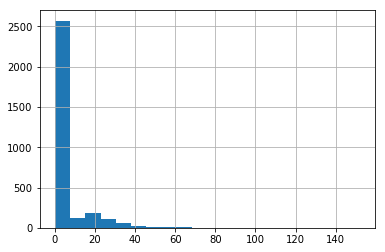

In [22]:
causes_plot['Drug-Induced Causes'].hist(bins=20)

In [23]:
# Make a colorscale based on the distribution of the values above
scl = [
    [0.0, 'rgb(254,229,217)'],
    [4.3, 'rgb(252,174,145)'],
    [15.0, 'rgb(251,106,74)'],
    [30.0, 'rgb(222,45,38)'],
    [45.0, 'rgb(165,15,21)']
                 ]

In [24]:
def pick_color_from_scale(x, colorscale):
    """Returns an rgb() color string from a given scale dependent on the value x"""
    
    insertion_index = bisect_left([item[0] for item in colorscale],x)
    
    if insertion_index>0:
        return colorscale[insertion_index-1][1]
    else:
        return colorscale[0][1]

In [25]:
# Add Drug-induced causes to the geodata

drugs_aar = dict()
for county in county_geo['features']:
    try:
        metric = causes_plot.loc[causes_plot['County Code']==float(county['id'])]['Drug-Induced Causes'].item()
    except ValueError:
        metric = 0
    county['drugs_aar'] = metric

### 3. Generate a plot of counties
This part generates a Plotly choropleth map with color-coded mortality rates due to drug-related causes. Due to the performance limitations of Plotly in this approach (using background layers instead of actual features to draw the map), the features are generated only for the counties where the age-adjusted rate was above zero.

In [26]:
# Iteratively add each county shape while picking a correspondent color from the colorscale
# Only add features for non-negative age-adj. death rate

county_layers = []
for county in county_geo['features']:
    if county['drugs_aar']>0.0: 
        tmp = dict(source = county,
                   sourcetype = 'geojson',
                   type = 'fill',
                   color = pick_color_from_scale(
                       x = county['drugs_aar'],
                       colorscale = scl),
                   opacity = 0.8
                  )
        county_layers.append(tmp)
    else:
        pass

In [27]:
county_layers[:2]

[{'color': 'rgb(251,106,74)',
  'opacity': 0.8,
  'source': {'drugs_aar': 20.9,
   u'geometry': {u'coordinates': [[[-87.76459, 31.298768],
      [-87.616713, 31.243998],
      [-87.600282, 30.997536],
      [-87.518128, 30.280057],
      [-88.005575, 30.685351],
      [-87.972714, 31.161844],
      [-87.945329, 31.194706],
      [-87.76459, 31.298768]]],
    u'type': u'Polygon'},
   u'id': u'1003',
   u'properties': {u'name': u'Baldwin'},
   u'type': u'Feature'},
  'sourcetype': 'geojson',
  'type': 'fill'},
 {'color': 'rgb(251,106,74)',
  'opacity': 0.8,
  'source': {'drugs_aar': 20.6,
   u'geometry': {u'coordinates': [[[-85.738122, 33.966038],
      [-85.529998, 33.94413],
      [-85.798368, 33.555267],
      [-86.143416, 33.681237],
      [-86.066738, 33.840068],
      [-85.738122, 33.966038]]],
    u'type': u'Polygon'},
   u'id': u'1015',
   u'properties': {u'name': u'Calhoun'},
   u'type': u'Feature'},
  'sourcetype': 'geojson',
  'type': 'fill'}]

In [28]:
with open('mapbox_token.txt', 'r') as f:
    mb_token = f.readlines(0)

In [29]:
mapbox_access_token = mb_token[0]

data = graph_objs.Data([

# We need this point to initialize the map as plotly requires a non-empty data array
    graph_objs.Scattermapbox(
        lat=['39.8333333'],
        lon=['-98.585522'],
        mode='markers',
        marker = dict(color='rgba(1,1,1,0.0)')
    )
])

layout = graph_objs.Layout(
    title = 'Counties with an age-adjusted death rate from drugs over 0 per 100k population in 2015',
    height= 800,
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        layers = county_layers,
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=39.8333333,
            lon=-98.585522
        ),
        pitch=0,
        zoom=3,
        style='light'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='county-level-choropleths-python')

We can see that not all counties have a high drug-related mortality, and the counties that have above-zero values and are visible on the map are probably the ones with higher population density (compare with this [map](https://media1.britannica.com/eb-media/89/71789-004-88879E35.gif))
  
In the final project, I am going to investigate how the death rates from drug-related causes changed over time, and also investigate if this death risk correlates with population density.

### Reference:

1) Mortality data: https://wonder.cdc.gov/cmf-icd10.html  
2) County-Level Choropleth visualizations with Plotly tutorial: https://plot.ly/python/county-level-choropleth/  
3) US County Geojson Source: http://python-visualization.github.io/folium/docs-master/quickstart.html  
4) Pandas documentation: https://pandas.pydata.org/pandas-docs/stable/  
